# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities?
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

1. Clean the data and perform some EDA and visualization to get to know the data set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


In [2]:
from google.colab import files
uploaded = files.upload()

Saving airbnb_hw.csv to airbnb_hw.csv


In [26]:
df = pd.read_csv("airbnb_hw.csv")
df.describe()

,Host Id,Review Scores Rating (bin),Zipcode,Beds,Number of Records,Number Of Reviews,Review Scores Rating
count,3.047800e+04,22155.000000,30344.000000,30393.000000,30478.0,30478.000000,22155.000000
mean,1.273171e+07,90.738659,10584.854831,1.530089,1.0,12.018735,91.993230
std,1.190270e+07,9.059519,921.299397,1.015359,0.0,21.980703,8.850373
min,5.000000e+02,20.000000,1003.000000,0.000000,1.0,0.000000,20.000000
25%,2.701298e+06,85.000000,10017.000000,1.000000,1.0,0.000000,89.000000
50%,8.551693e+06,90.000000,10065.000000,1.000000,1.0,3.000000,94.000000
75%,2.120617e+07,100.000000,11216.000000,2.000000,1.0,13.000000,100.000000
max,4.303307e+07,100.000000,99135.000000,16.000000,1.0,257.000000,100.000000


**Important Insights**

Price

The average price across listings is approximately \$155, with a median of \$125. Prices range from \$10 to \$10,000, with the interquartile range falling between \$85 and \$190.

Number of Reviews

Listings receive an average of 16.5 reviews, but the distribution is skewed. The median is only 7, while the maximum is 257. This indicates that most listings receive relatively few reviews.

Review Scores Rating

The mean review score is around 92 and 75% of the listings score a perfect 100. This suggests high rating saturation, making it harder to differentiate between listings. A small number of listings received very low scores, with the minimum being 20.

In [27]:
#Drop columns
df.drop(columns=['Host Id', 'Name', 'Host Since'], inplace=True)

#Remove commas and convert to float
df['Price'] = df['Price'].str.replace(',', '').astype(float)

#Remove spaces from column names
df.columns = df.columns.str.strip()

#Remove rows with missing and zero prices
df = df[df['Price'].notnull() & (df['Price'] > 0)]
df = df[df['Beds'] > 0]


#Drop rows with missing key values
df = df.dropna(subset=['Review Scores Rating', 'Beds', 'Number Of Reviews'])

#Make sure data types are right
df['Price'] = df['Price'].astype(float)
df['Beds'] = df['Beds'].astype(int)
df['Number Of Reviews'] = df['Number Of Reviews'].astype(int)




In [24]:
df.head()

,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
4,Manhattan,Apartment,95.0,Private room,10036.0,3,1,39,549.0,96.0
5,Brooklyn,Apartment,100.0,Entire home/apt,11222.0,1,1,4,149.0,100.0
6,Manhattan,Apartment,100.0,Entire home/apt,10004.0,1,1,9,250.0,100.0
7,Brooklyn,Apartment,90.0,Private room,11201.0,1,1,80,90.0,94.0
8,Manhattan,Apartment,90.0,Entire home/apt,10009.0,2,1,95,270.0,90.0


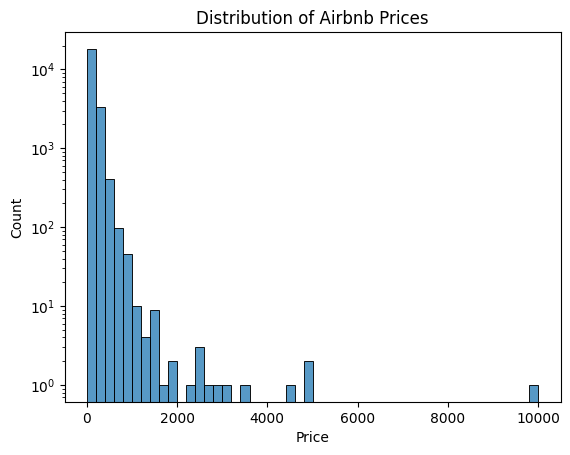

In [28]:
#Histogram of price
sns.histplot(df['Price'], bins=50)
plt.yscale('log') #log scale to handle outliers
plt.title('Distribution of Airbnb Prices')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

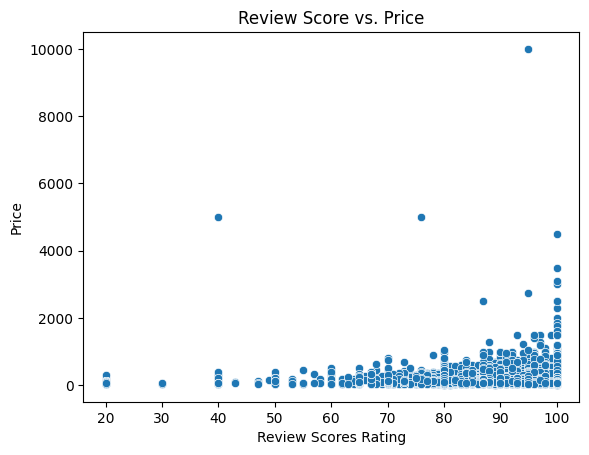

In [7]:
#Scatter plot for Review Score vs. Price
sns.scatterplot(data=df, x='Review Scores Rating', y='Price')
plt.title('Review Score vs. Price')
plt.show()

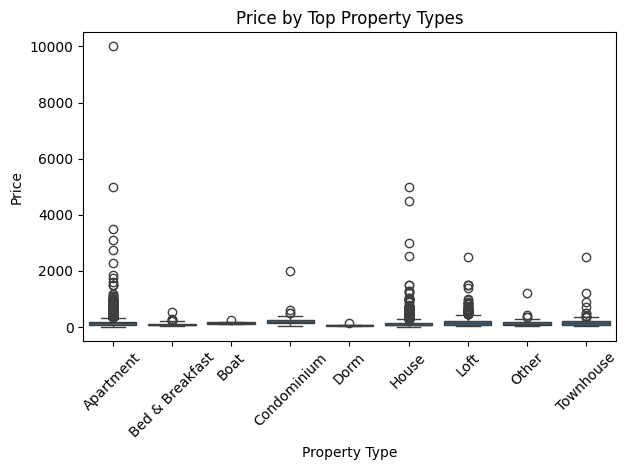

In [29]:
#Top 6 property types
top_types = df['Property Type'].value_counts().nlargest(9).index
df_top = df[df['Property Type'].isin(top_types)]
sorted_types = sorted(top_types)


#Plot top property types
sns.boxplot(data=df_top, x='Property Type', y='Price', order=sorted_types)
plt.title('Price by Top Property Types')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


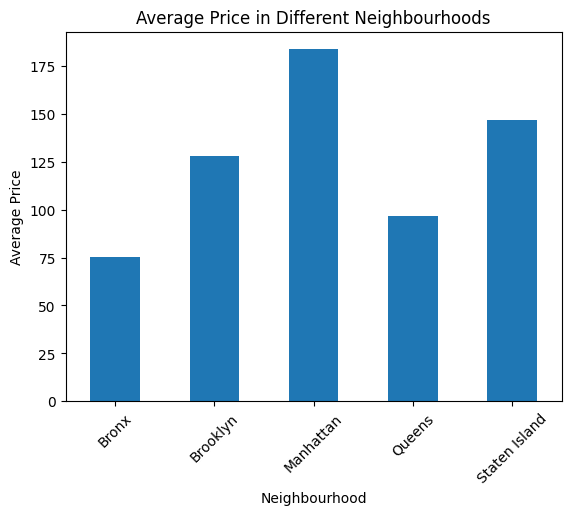

In [32]:
#Average price by neighborhood
avg_price = df.groupby('Neighbourhood')['Price'].mean()
avg_price.plot(kind='bar')
plt.title('Average Price in Different Neighbourhoods')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()



Question 2

In [31]:
df.dtypes

,0
Neighbourhood,object
Property Type,object
Review Scores Rating (bin),float64
Room Type,object
Zipcode,float64
Beds,int64
Number of Records,int64
Number Of Reviews,int64
Price,float64
Review Scores Rating,float64


In [33]:
#Convert categorical variables into dummy variables for modeling
ddf = pd.get_dummies(df, columns=['Neighbourhood', 'Property Type', 'Room Type'], drop_first=True)
ddf.head()

,Review Scores Rating (bin),Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating,Neighbourhood_Brooklyn,Neighbourhood_Manhattan,Neighbourhood_Queens,...,Property Type_House,Property Type_Hut,Property Type_Lighthouse,Property Type_Loft,Property Type_Other,Property Type_Townhouse,Property Type_Treehouse,Property Type_Villa,Room Type_Private room,Room Type_Shared room
4,95.0,10036.0,3,1,39,549.0,96.0,False,True,False,...,False,False,False,False,False,False,False,False,True,False
5,100.0,11222.0,1,1,4,149.0,100.0,True,False,False,...,False,False,False,False,False,False,False,False,False,False
6,100.0,10004.0,1,1,9,250.0,100.0,False,True,False,...,False,False,False,False,False,False,False,False,False,False
7,90.0,11201.0,1,1,80,90.0,94.0,True,False,False,...,False,False,False,False,False,False,False,False,True,False
8,90.0,10009.0,2,1,95,270.0,90.0,False,True,False,...,False,False,False,False,False,False,False,False,False,False


Question 3

In [34]:
from sklearn.model_selection import train_test_split

In [36]:
#Define target and features
y = ddf['Price']
X = ddf.drop(columns=['Price'])

#Create 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Question 4

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [42]:
#Model 1 - Predict price using only 'Beds'
X1 = X_train[['Beds']]
X1_test = X_test[['Beds']]

model1 = LinearRegression().fit(X1, y_train)

#Predictions
y_train_pred1 = model1.predict(X1)
y_test_pred1 = model1.predict(X1_test)

#Metrics
rmse_train1 = np.sqrt(mean_squared_error(y_train, y_train_pred1))
rmse_test1 = np.sqrt(mean_squared_error(y_test, y_test_pred1))
r2_train1 = r2_score(y_train, y_train_pred1)
r2_test1 = r2_score(y_test, y_test_pred1)


print("Model 1: Price ~ Beds")
print(f"Train RMSE: {rmse_train1:.2f}, R²: {r2_train1:.3f}")
print(f"Test RMSE: {rmse_test1:.2f}, R²: {r2_test1:.3f}")



Model 1: Price ~ Beds
Train RMSE: 133.76, R²: 0.133
Test RMSE: 155.85, R²: 0.141


In [43]:
#Model 2 - Predict price using only 'Number Of Reviews' and Neighbourhood dummies
features = ['Number Of Reviews'] + [col for col in ddf.columns if col.startswith('Neighbourhood_')]

X2_train = X_train[features]
X2_test = X_test[features]

model2 = LinearRegression().fit(X2_train, y_train)

y_train_pred2 = model2.predict(X2_train)
y_test_pred2 = model2.predict(X2_test)

rmse_train2 = np.sqrt(mean_squared_error(y_train, y_train_pred2))
rmse_test2 = np.sqrt(mean_squared_error(y_test, y_test_pred2))
r2_train2 = r2_score(y_train, y_train_pred2)
r2_test2 = r2_score(y_test, y_test_pred2)

print("Model 2: Price ~ Number of Reviews + Neighbourhood")
print(f"Train RMSE: {rmse_train2:.2f}, R²: {r2_train2:.3f}")
print(f"Test RMSE: {rmse_test2:.2f}, R²: {r2_test2:.3f}")


Model 2: Price ~ Number of Reviews + Neighbourhood
Train RMSE: 139.99, R²: 0.051
Test RMSE: 165.16, R²: 0.035


In [44]:
#Model 3 - Predict price using 'Review Scores Rating' and Neighbourhood dummies
features = ['Review Scores Rating'] + [col for col in ddf.columns if col.startswith('Neighbourhood_')]

X3_train = X_train[features]
X3_test = X_test[features]

model3 = LinearRegression().fit(X3_train, y_train)

y_train_pred3 = model3.predict(X3_train)
y_test_pred3 = model3.predict(X3_test)

rmse_train3 = np.sqrt(mean_squared_error(y_train, y_train_pred3))
rmse_test3 = np.sqrt(mean_squared_error(y_test, y_test_pred3))
r2_train3 = r2_score(y_train, y_train_pred3)
r2_test3 = r2_score(y_test, y_test_pred3)

print("Model 3: Price ~ Review Scores Rating + Neighbourhood")
print(f"Train RMSE: {rmse_train3:.2f}, R²: {r2_train3:.3f}")
print(f"Test RMSE: {rmse_test3:.2f}, R²: {r2_test3:.3f}")


Model 3: Price ~ Review Scores Rating + Neighbourhood
Train RMSE: 139.63, R²: 0.056
Test RMSE: 165.38, R²: 0.032


In [45]:
# Model 4 - Predict price using 'Beds', 'Review Scores Rating', and Neighbourhood dummies
features = ['Beds', 'Review Scores Rating'] + [col for col in ddf.columns if col.startswith('Neighbourhood_')]

X4_train = X_train[features]
X4_test = X_test[features]

model4 = LinearRegression().fit(X4_train, y_train)

y_train_pred4 = model4.predict(X4_train)
y_test_pred4 = model4.predict(X4_test)

rmse_train4 = np.sqrt(mean_squared_error(y_train, y_train_pred4))
rmse_test4 = np.sqrt(mean_squared_error(y_test, y_test_pred4))
r2_train4 = r2_score(y_train, y_train_pred4)
r2_test4 = r2_score(y_test, y_test_pred4)

print("Model 4: Price ~ Review Scores Rating + Beds")
print(f"Train RMSE: {rmse_train4:.2f}, R²: {r2_train4:.3f}")
print(f"Test RMSE: {rmse_test4:.2f}, R²: {r2_test4:.3f}")


Model 4: Price ~ Review Scores Rating + Beds
Train RMSE: 128.52, R²: 0.200
Test RMSE: 152.24, R²: 0.180


The Review Scores Rating + Beds is still not the strongest, but it is what captures the best RMSE compared to the other combinations.

Question 5

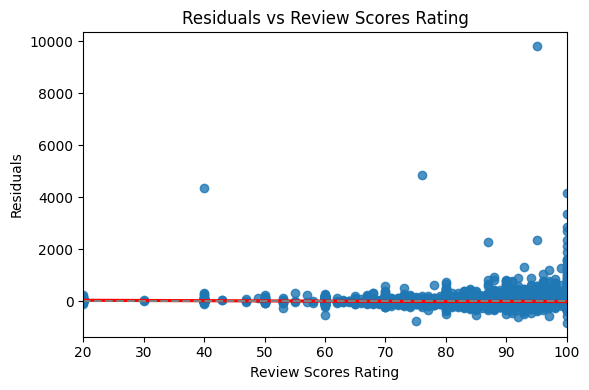

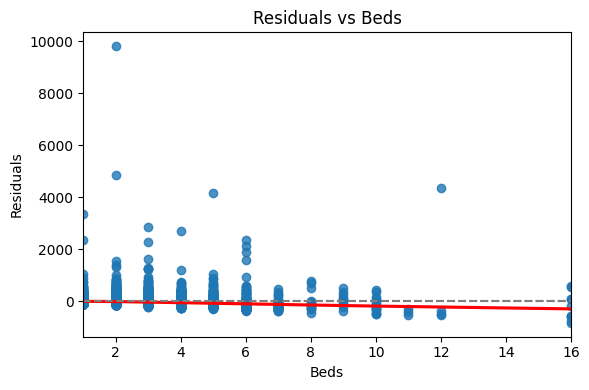

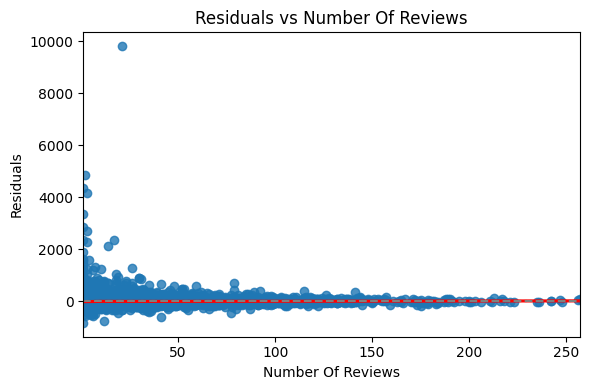

In [48]:
#Fit model with Beds + Review Scores Rating
features = ['Review Scores Rating', 'Beds', 'Number Of Reviews']

X = ddf[features]
y = ddf['Price']

model = LinearRegression().fit(X, y)
y_pred = model.predict(X)
residuals = y - y_pred

#Plot residuals vs each feature
for feature in features:
    plt.figure(figsize=(6, 4))
    sns.residplot(x=ddf[feature], y=residuals, lowess=True, line_kws={'color': 'red'})
    plt.title(f"Residuals vs {feature}")
    plt.xlabel(feature)
    plt.ylabel("Residuals")
    plt.axhline(0, linestyle='--', color='gray')
    plt.tight_layout()
    plt.show()


For Review Scores Rating, the residuals widen at higher values. In the Beds plot, some large outliers appear at low bed counts. The Number of Reviews plot shows high residuals at low review counts.

Question 6

In [49]:
#Add transformed (log) and interaction (Beds × Rating) features for modeling
ddf['Log_Reviews'] = np.log1p(ddf['Number Of Reviews'])  # log(Number of Reviews + 1)
ddf['Beds_x_Rating'] = ddf['Beds'] * ddf['Review Scores Rating']

#Define features
features = ['Beds', 'Review Scores Rating', 'Log_Reviews', 'Beds_x_Rating']

#Train-test split
X_complex = ddf[features]
y_complex = ddf['Price']
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_complex, y_complex, test_size=0.2, random_state=42)

#Fit model
model_c = LinearRegression().fit(X_train_c, y_train_c)

#Predictions
y_train_pred_c = model_c.predict(X_train_c)
y_test_pred_c = model_c.predict(X_test_c)

#Evaluation
rmse_train_c = np.sqrt(mean_squared_error(y_train_c, y_train_pred_c))
rmse_test_c = np.sqrt(mean_squared_error(y_test_c, y_test_pred_c))
r2_train_c = r2_score(y_train_c, y_train_pred_c)
r2_test_c = r2_score(y_test_c, y_test_pred_c)

print("Complex Model: Beds + Rating + log(Reviews) + Beds×Rating")
print(f"Train RMSE: {rmse_train_c:.2f}, R²: {r2_train_c:.3f}")
print(f"Test RMSE: {rmse_test_c:.2f}, R²: {r2_test_c:.3f}")


Complex Model: Beds + Rating + log(Reviews) + Beds×Rating
Train RMSE: 132.82, R²: 0.146
Test RMSE: 157.73, R²: 0.120


The more complex model was worse than the simplest models. Despite having an interaction term and a transformation, it had a poorer R² and higher test RMSE than the simple model, which used only Beds and Review Scores Rating. This is evidence that additional complication did not add to predictive power and may have introduced unnecessary noise.

Question 7

Upon building and comparing various models, I found that a basic linear regression with just Beds and Review Scores Rating was the best performing, having both the lowest RMSE and highest R² on test and training data. Attempts at improving the model by adding log(Number of Reviews) and an interaction term (Beds × Rating) did not create improved performance and actually slightly reduced the ability of the model to generalize. This helps to highlight the importance of trading off complexity for interpretability and serves to show that additional features don't always translate to improved model accuracy.